# Aula 1.2 — Introdução a Embeddings - Embeddings

# Instalação dos pacotes necessários / Configuração da máquina

In [1]:
# Instalação das dependências localmente
# Se estiver rodando localmente, descomente a linha abaixo para instalar as dependências
# ! pip install -r requirements.txt

In [2]:
# Se rodando no Google Colab, descomente a linha abaixo para montar o Google Drive
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
# Instalação das dependências no Google Colab
# Mude CAMINHO_PARA_REPO para o caminho correto do seu repositório no seu Google Drive
# ! pip install -r /content/drive/MyDrive/UFMS/Aulas/2025-2/TOPIA/repo/TopicosIA-2025-02/requirements.txt

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
from gensim.models import Word2Vec

## Onde estávamos: representações vetoriais tradicionais
- **One-hot:** vetor esparso com 1 na posição da palavra e 0 no resto.  
- **BoW (bag-of-words):** conta frequências de palavras, **ignora ordem**.  
- **n-gramas:** leva em conta sequências de tamanho *n* (ex.: bigramas), porém o espaço cresce muito.

**Consequência:** essas representações são úteis, mas **não codificam semelhança semântica** (ex.: *bom* vs *ótimo* são ortogonais em one-hot) e podem **falhar com negação** e **ordem**.

In [5]:
import numpy as np
from collections import Counter

def cosine(u, v, eps=1e-9):
    u = np.array(u, dtype=float); v = np.array(v, dtype=float)
    return float(u.dot(v) / (np.linalg.norm(u)*np.linalg.norm(v) + eps))

# Vocabulário pequeno para ilustração
vocab = ["o","filme","é","não","bom","ótimo","atendeu","paciente","hospital"]
tok2idx = {t:i for i,t in enumerate(vocab)}

def bow_vector(tokens):
    x = np.zeros(len(vocab), dtype=float)
    for t in tokens:
        if t in tok2idx: x[tok2idx[t]] += 1
    return x

s1 = "o filme é bom".split()
s2 = "o filme é ótimo".split()
s3 = "o filme não é bom".split()

v1, v2, v3 = map(bow_vector, [s1,s2,s3])

print("cos( 'o filme é bom', 'o filme é ótimo'):", round(cosine(v1,v2),3))
print("cos( 'o filme é bom', 'o filme não é bom'):", round(cosine(v1,v3),3))

cos( 'o filme é bom', 'o filme é ótimo'): 0.75
cos( 'o filme é bom', 'o filme não é bom'): 0.894


### Ordem importa, e BoW não vê
Com BoW, **“o paciente atendeu o hospital”** e **“o hospital atendeu o paciente”** são idênticas.  
Bigramas ajudam um pouco, mas o **número de features explode**.

In [6]:
def ngrams(tokens, n=2):
    return ["_".join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def vec_from_counts(counts, vocab):
    x = np.zeros(len(vocab), dtype=float)
    for i,t in enumerate(vocab):
        x[i] = counts.get(t, 0.0)
    return x

a = "o hospital atendeu o paciente".split()
b = "o paciente atendeu o hospital".split()

# BoW (unigramas)
u_vocab = vocab  # já definido
ua, ub = bow_vector(a), bow_vector(b)

# Bigramas
bigrams_a = Counter(ngrams(a,2))
bigrams_b = Counter(ngrams(b,2))
b_vocab = sorted(list(set(list(bigrams_a)+list(bigrams_b))))
xba = vec_from_counts(bigrams_a, b_vocab)
xbb = vec_from_counts(bigrams_b, b_vocab)

print("BoW (ignora ordem) — cos:", round(cosine(ua,ub),3), "(idênticas)")
print("Bigramas (vê ordem)  — cos:", round(cosine(xba,xbb),3), "(diferentes)")

BoW (ignora ordem) — cos: 1.0 (idênticas)
Bigramas (vê ordem)  — cos: 0.75 (diferentes)


### Por que n-gramas não escalam?
- Com vocabulário \(V\), o número potencial de **bigramas** é \(O(V^2)\); de **trigramas**, \(O(V^3)\).  
- Mesmo usando estruturas **esparsas**, o custo de memória/treino cresce rápido e muitos n-gramas raramente aparecem.

**Moral da história:** precisamos de **vetores densos** que **generalizem** além do que foi visto *literalmente*.

In [7]:
def possible_ngrams(V, n):  # estimativa grosseira O(V^n)
    return V**n

for V in [5_000, 50_000]:
    print(f"\nVocabulário V={V:,}")
    for n in [1,2,3]:
        print(f"  n={n}: ~{possible_ngrams(V,n):,} features potenciais")


Vocabulário V=5,000
  n=1: ~5,000 features potenciais
  n=2: ~25,000,000 features potenciais
  n=3: ~125,000,000,000 features potenciais

Vocabulário V=50,000
  n=1: ~50,000 features potenciais
  n=2: ~2,500,000,000 features potenciais
  n=3: ~125,000,000,000,000 features potenciais


## O que são **embeddings**?

- Uma **função aprendida** que mapeia palavras, sub-palavras ou sentenças para **vetores densos** de baixa dimensão:

$$
f: \mathcal{X} \to \mathbb{R}^d \quad \text{com} \quad d \ll |\mathcal{X}|
$$

- **Princípio distribucional:** palavras com **contextos semelhantes** tendem a ter **vetores próximos** (alto cosseno).  
- **Geometria útil:** *direções* e *distâncias* capturam relações (semelhança, analogias).

Imagine num **mapa semântico**: *praia* fica perto de *mar*, longe de *hospital*; *médico* se aproxima de *saúde*, etc.

### Vantagens sobre BoW / n-gramas

- **Compartilham informação** entre palavras parecidas (ex.: *bom* e *ótimo*).  
- **Generalizam** para contextos não vistos literalmente.  
- Dimensão **controlada** (50–768+), em vez de crescer com:

$$
V, \quad V^2, \quad V^3
$$

## Como aprendemos embeddings? (alto nível)
- **Word2Vec (Skip-gram/CBOW):** aprende vetores prevendo **contexto** da palavra (ou vice-versa).  
- **GloVe:** fatoração explícita de coocorrências globais.  
- **fastText:** soma vetores de **sub-palavras** (n-gramas de caracteres) → lida melhor com OOV e morfologia.  
- **Embeddings contextuais (ELMo/BERT):** um vetor **por ocorrência**, dependente do **contexto** na sentença.

## Experimento inicial
Vamos “sentir” na prática as limitações que motivam embeddings.
1. **One-hot**: qualquer par de palavras diferentes tem cosseno \(0\).  
2. **BoW**: frases com **negação** ou **ordem invertida** podem parecer erroneamente parecidas.  
3. **Bigramas**: corrigem parcialmente, mas **não escalam**.

In [8]:
# (1) One-hot não codifica semelhança: 'bom' ~ 'ótimo'?
def one_hot(word, vocab):
    x = np.zeros(len(vocab), dtype=float)
    if word in tok2idx: x[tok2idx[word]] = 1.0
    return x

oh_bom = one_hot("bom", vocab)
oh_otimo = one_hot("ótimo", vocab)

print("cos(one-hot('bom'), one-hot('ótimo')) =", cosine(oh_bom, oh_otimo), "(zero)")

cos(one-hot('bom'), one-hot('ótimo')) = 0.0 (zero)


In [9]:
# (2) BoW erra na negação; (3) Bigramas ajudam um pouco
neg = "o filme não é bom".split()
pos = "o filme é bom".split()

bow_neg, bow_pos = bow_vector(neg), bow_vector(pos)
bi_neg = Counter(ngrams(neg,2)); bi_pos = Counter(ngrams(pos,2))
b_vocab = sorted(list(set(list(bi_neg)+list(bi_pos))))
xneg, xpos = vec_from_counts(bi_neg, b_vocab), vec_from_counts(bi_pos, b_vocab)

print("BoW  — cos(neg, pos) =", round(cosine(bow_neg, bow_pos),3))
print("Bi-gramas — cos(neg, pos) =", round(cosine(xneg, xpos),3))

BoW  — cos(neg, pos) = 0.894
Bi-gramas — cos(neg, pos) = 0.577


## Breve história (do macro ao micro)
- **Anos 1990 — LSA/LSI:** fatoração (SVD) de matrizes termo-documento gera vetores densos.  
- **2003 — Neural Probabilistic LM (Bengio et al.):** primeiras redes neurais aprendendo embeddings junto com o LM.  
- **2013 — Word2Vec:** *skip-gram* / *CBOW* com *negative sampling* (rápido, popularizou embeddings).  
- **2014 — GloVe:** vetores a partir de coocorrências globais.  
- **2016/17 — fastText:** incorpora **sub-palavras** (morfologia e OOV).  
- **2018 — ELMo/BERT:** **embeddings contextuais** (um vetor por ocorrência).  
- **2019+ — Sentence-BERT e afins:** bons **embeddings de sentenças** para busca e recuperação.  
- **2020s — LLMs (GPT, etc.):** camadas internas geram representações ricas; APIs fornecem **embeddings universais**.

## Intuição

- **One-hot**: cada palavra → vetor esparso com 1 numa posição. Sem noção de semelhança.
- **Embeddings**: mapeiam cada palavra para um vetor **denso** de baixa dimensão (ex.: 50–300), aprendidos a partir de contexto.
- Ideia central (*Distribucional*): “Vocês conhecerão uma palavra pelo **contexto** que ela mantém”.

### Do ponto de vista computacional

- Vocabulário com $$V$$ palavras. Dimensão do embedding $$d \ll V$$.  
- Tabela $$E \in \mathbb{R}^{V \times d}$$. A palavra $$w_i$$ tem vetor $$\mathbf{e}_i = E[i]$$.

- Similaridade por **cosseno**:

$$
\text{cos}(\mathbf{u}, \mathbf{v}) = \frac{\mathbf{u}\cdot\mathbf{v}}{\|\mathbf{u}\|\;\|\mathbf{v}\|}
$$

## De one-hot a vetores densos
Vamos construir vetores one-hot e comparar com embeddings aleatórios (apenas para enxergar a diferença de forma).

In [ ]:
# Vocabulário de exemplo
vocab = ["brasil", "rio", "sao_paulo", "praia", "futebol", "selva", "amazonia", "cafe", "universidade", "hospital"]
idx = {w:i for i,w in enumerate(vocab)}
V = len(vocab)
d = 5  # dimensão dos embeddings "densos" para visualização

# One-hot
I = np.eye(V)

# Embeddings densos aleatórios
np.random.seed(42)
E_rand = np.random.normal(scale=0.5, size=(V,d))

print("One-hot shape:", I.shape)
print("Embeddings densos shape:", E_rand.shape)

One-hot shape: (10, 10)
Embeddings densos shape: (10, 5)


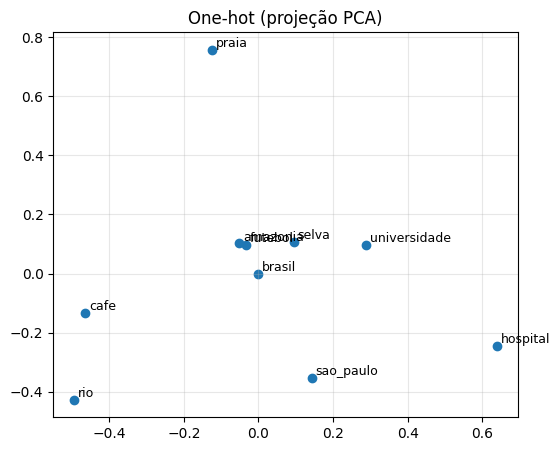

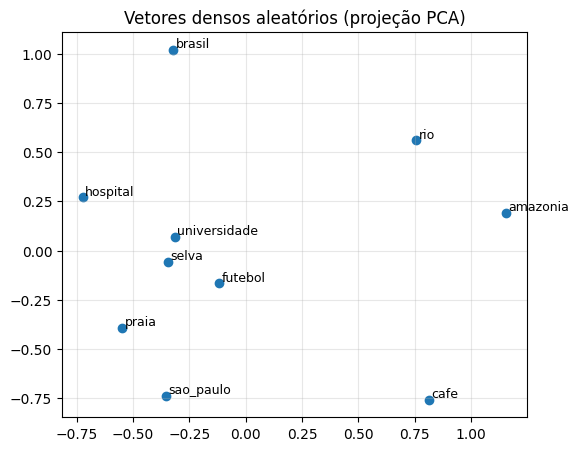

In [11]:
# Visualização simples (PCA) dos embeddings aleatórios vs one-hot
def plot_points(X, labels, title):
    pca = PCA(n_components=2, random_state=0)
    X2 = pca.fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1], c="tab:blue")
    for i, txt in enumerate(labels):
        plt.annotate(txt, (X2[i,0]+0.01, X2[i,1]+0.01), fontsize=9)
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

plot_points(I, vocab, "One-hot (projeção PCA)")
plot_points(E_rand, vocab, "Vetores densos aleatórios (projeção PCA)")

**Observação:** One-hot não captura relação entre palavras. Já vetores densos *podem* capturar (se aprendidos de dados). Vamos treinar rapidamente um **Word2Vec** em um corpus pequeno de frases em PT-BR para demonstrar a ideia (não esperem qualidade de produção).  
*Siglas usadas*: OOV (*Out-Of-Vocabulary*), PCA (Análise de Componentes Principais), t-SNE (*t-distributed Stochastic Neighbor Embedding*).

In [29]:
corpus = [
    "o brasil gosta de futebol",
    "o rio tem praia bonita",
    "sao paulo tem universidade e hospital",
    "a amazonia tem selva e rios",
    "o brasil produz cafe",
    "o rio de janeiro tem futebol e praia",
    "sao paulo tem hospital famoso",
    "a universidade pesquisa inteligencia artificial",
    "cafe do brasil é famoso",
    "a selva da amazonia é densa",
    "o hospital do rio é universitario",

    "o cruzeiro é o melhor time do brasil",
    "o time de futebol joga no estadio",
    "a torcida canta no estadio",
    "o jogador marcou um gol",
    "o tecnico escala o time titular",
    "o campeonato brasileiro tem rodada no domingo",
    "o arbitro apita o jogo de futebol",
    "o atacante fez dois gols no classico",
    "o goleiro defendeu o penalti",
    "o time treinou no campo de grama",
    "o maracana fica no rio de janeiro",
    "o morumbi fica em sao paulo",
    "o estadio recebe finais importantes",
    "o time carioca venceu o jogo",
    "o time paulista empatou fora de casa",
    "a base revela novos jogadores",
    "o lateral cruza a bola para a area",
    "o meio campista organiza o ataque",
    "o zagueiro corta o cruzamento",
    "o treinador analisa estatisticas do jogo",

    "a praia de copacabana tem areia branca",
    "ipanema tem mar e sol",
    "o turista caminha no calcadao de copacabana",
    "o surfista pega onda na praia",
    "banhistas lotam a praia no verao",
    "o quiosque vende agua de coco",
    "o rio tem orla movimentada",
    "a brisa do mar refresca a tarde",
    "a praia tem guarda sol e cadeira",
    "o por do sol em ipanema é bonito",
    "o passeio de bicicleta na orla é popular",

    "a universidade tem campus grande",
    "o campus tem biblioteca e laboratorio",
    "o professor orienta estudante de mestrado",
    "a pesquisa em dados utiliza python",
    "o laboratorio de ia treina redes neurais",
    "a pos graduacao publica artigos cientificos",
    "o grupo de pesquisa organiza seminario semanal",
    "a universidade federal tem curso de computacao",
    "o aluno estuda no laboratorio de informatica",
    "a disciplina ensina machine learning",
    "o dataset tem noticias do brasil",
    "a avaliacao usa acuracia e f1",
    "o modelo aprende representacoes distribuídas",
    "o repositorio guarda codigo e dados",
    "o professor apresenta resultados no congresso",
    "o curso tem prova e projeto final",
    "a biblioteca empresta livros e revistas",
    "a universidade tem hospital universitario",
    "a pesquisa em linguagem natural usa word2vec",
    "o laboratorio de visao computacional anota imagens",
    "a turma pratica classificacao de textos",
    "o servidor treina o modelo com gpu",
    "a extensao conecta universidade e comunidade",
    "o estagio aproxima alunos do mercado",

    "o hospital universitario atende pacientes",
    "o medico realiza cirurgia no centro cirurgico",
    "a enfermeira aplica vacina na sala de atendimento",
    "o paciente marcou consulta com o especialista",
    "a emergencia recebe ambulancia a noite",
    "o laboratorio realiza exame de sangue",
    "o hospital tem leitos e uti",
    "a saude publica contrata medicos",
    "o medico receita medicamento para o paciente",
    "o hospital de sao paulo e referencia",
    "o pronto socorro fica lotado no feriado",
    "a vacina previne doenca infecciosa",
    "a farmacia do hospital entrega remedio",
    "a triagem organiza a fila de atendimento",
    "o prontuario registra historico do paciente",

    "a amazonia abriga grande biodiversidade",
    "o rio amazonas corta a floresta",
    "o rio negro encontra o rio solimoes",
    "a floresta tem arvores altas e lianas",
    "a chuva e intensa na amazonia",
    "comunidades indigenas vivem na regiao",
    "o pesquisador estuda fauna e flora",
    "o boto cor de rosa nada no rio",
    "o peixe e alimento importante na regiao",
    "o parque nacional protege a mata",
    "o desmatamento ameaca a floresta",
    "o ibama fiscaliza a regiao amazonica",
    "o clima e umido e quente na floresta",
    "barcos transportam pessoas pelos rios",
    "manaus tem porto no rio negro",
    "belem fica proxima da foz do amazonas",

    "o cafe de minas gerais tem qualidade",
    "a fazenda colhe graos maduros de cafe",
    "a torra define o sabor do cafe",
    "o barista prepara espresso na cafeteria",
    "a xicara de cafe acompanha o pao de queijo",
    "o brasil exporta cafe para a europa",
    "o cafe especial recebe pontuacao alta",
    "sao paulo tem muitas cafeterias",
    "o produtor investe em irrigacao por gotejamento",
    "a cooperativa vende graos torrados",
    "o cafe arabica cresce em altitude",
    "o cafe robusta cresce no espirito santo",

    "brasilia e a capital do brasil",
    "belo horizonte tem feira de artesanato",
    "curitiba tem parque bonito e organizado",
    "salvador tem carnaval famoso",
    "fortaleza tem praia do futuro movimentada",
    "recife tem o porto digital de tecnologia",
    "porto alegre tem inverno frio",
    "florianopolis tem muitas praias e trilhas",
    "natal tem duna e passeio de buggy",
    "gramado recebe muitos turistas no inverno",

    "o estadio maracana recebe finais e classicos de futebol",
    "o morumbi recebe shows e jogos de futebol",
    "o campus da universidade tem hospital universitario",
    "o hospital universitario participa de pesquisa clinica",
    "a universidade organiza torneio de futebol entre cursos",
    "a praia de copacabana recebe turistas e atletas",
    "o laboratorio de dados analisa estatisticas do campeonato",
    "o time treina na academia do clube",
    "a cafeteria do campus serve cafe especial",
    "o congresso de ia ocorre em sao paulo",
    "o museu do "
    "futebol fica no estadio do pacaembu",
    "o centro de inovacao conecta startups e universidade",
]

In [ ]:
# 3) Treino rápido de Word2Vec com Gensim (toy)
# corpus = [
#     "o brasil gosta de futebol",
#     "o rio tem praia bonita",
#     "sao paulo tem universidade e hospital",
#     "a amazonia tem selva e rios",
#     "o brasil produz cafe",
#     "o rio de janeiro tem futebol e praia",
#     "sao paulo tem hospital famoso",
#     "a universidade pesquisa inteligencia artificial",
#     "cafe do brasil é famoso",
#     "a selva da amazonia é densa",
#     "o hospital do rio é universitario",
# ]

# Tokenização bem simples (minúsculas e split)
sentences = [s.lower().split() for s in corpus]

w2v = Word2Vec(
    sentences=sentences,
    vector_size=150,   # dimensão do embedding
    window=3,         # tamanho do contexto
    min_count=1,      # mantém todas as palavras do nosso mini-corpus
    sg=1,             # 1 = skip-gram, 0 = CBOW
    epochs=200,       # mais épocas pra compensar corpus pequeno
    seed=42
)

print("Palavras no vocabulário:", list(w2v.wv.key_to_index.keys()))

Palavras no vocabulário: ['o', 'a', 'de', 'tem', 'e', 'do', 'no', 'cafe', 'rio', 'hospital', 'na', 'universidade', 'praia', 'futebol', 'recebe', 'time', 'brasil', 'em', 'laboratorio', 'é', 'sao', 'paulo', 'pesquisa', 'fica', 'universitario', 'estadio', 'campus', 'organiza', 'amazonia', 'floresta', 'regiao', 'sol', 'treina', 'copacabana', 'jogo', 'dados', 'paciente', 'da', 'para', 'porto', 'famoso', 'amazonas', 'parque', 'estatisticas', 'corta', 'ipanema', 'mar', 'finais', 'usa', 'negro', 'graos', 'analisa', 'conecta', 'vende', 'modelo', 'curso', 'com', 'medico', 'realiza', 'centro', 'vacina', 'publica', 'atendimento', 'ia', 'orla', 'professor', 'biblioteca', 'grande', 'estuda', 'bonito', 'por', 'guarda', 'movimentada', 'passeio', 'congresso', 'morumbi', 'cafeteria', 'turistas', 'selva', 'rios', 'janeiro', 'inverno', 'marcou', 'maracana', 'campeonato', 'muitas', 'especial', 'cresce', 'jogadores', 'graduacao', 'paulista', 'inteligencia', 'seminario', 'artificial', 'grupo', 'cientificos',

In [13]:
# %%
# 4) Funções auxiliares: similaridade por cosseno e vizinhos mais próximos
from numpy.linalg import norm

def cosine(u, v, eps=1e-9):
    u = np.array(u); v = np.array(v)
    return float(u.dot(v) / (norm(u)*norm(v) + eps))

def nearest_neighbors(model, query, topk=5):
    if query not in model.wv:
        return []
    qv = model.wv[query]
    words = []
    sims = []
    for w in model.wv.index_to_key:
        if w == query:
            continue
        s = cosine(qv, model.wv[w])
        words.append(w); sims.append(s)
    order = np.argsort(sims)[::-1][:topk]
    return [(words[i], sims[i]) for i in order]

for q in ["brasil", "rio", "universidade", "praia", "hospital", "amazonia"]:
    print(f"\nMais próximos de '{q}':")
    for w,s in nearest_neighbors(w2v, q, topk=5):
        print(f"  {w:15s}  cos={s: .3f}")


Mais próximos de 'brasil':
  selva            cos= 0.580
  tem              cos= 0.480
  hospital         cos= 0.429
  futebol          cos= 0.414
  gosta            cos= 0.401

Mais próximos de 'rio':
  densa            cos= 0.402
  famoso           cos= 0.358
  a                cos= 0.353
  futebol          cos= 0.341
  de               cos= 0.339

Mais próximos de 'universidade':
  a                cos= 0.348
  janeiro          cos= 0.317
  pesquisa         cos= 0.288
  é                cos= 0.268
  densa            cos= 0.267

Mais próximos de 'praia':
  selva            cos= 0.465
  futebol          cos= 0.401
  tem              cos= 0.356
  de               cos= 0.315
  bonita           cos= 0.304

Mais próximos de 'hospital':
  tem              cos= 0.480
  selva            cos= 0.457
  brasil           cos= 0.429
  densa            cos= 0.419
  da               cos= 0.396

Mais próximos de 'amazonia':
  a                cos= 0.568
  pesquisa         cos= 0.521
  janeiro       

## Analogias
Analogias famosas do tipo *rei − homem + mulher ≈ rainha* tendem a emergir em embeddings maiores e com muito dado.  
Com nosso corpus pequeno, veremos apenas um **exemplo didático**.

In [28]:
def analogy(model, a, b, c, topk=5):
    # a : b :: c : ?
    if not all(w in model.wv for w in [a,b,c]):
        return []
    vec = model.wv[b] - model.wv[a] + model.wv[c]
    words = []
    sims = []
    for w in model.wv.index_to_key:
        if w in [a,b,c]:
            continue
        s = cosine(vec, model.wv[w])
        words.append(w); sims.append(s)
    order = np.argsort(sims)[::-1][:topk]
    return [(words[i], sims[i]) for i in order]

print("Exemplo de analogia (qual palavra se aproxima de 'rio' - 'praia' + 'sao'):")
print(analogy(w2v,  "rio", "praia","sao"))

Exemplo de analogia (qual palavra se aproxima de 'rio' - 'praia' + 'sao'):
[('tem', 0.3088916651558892), ('selva', 0.2537997910508114), ('janeiro', 0.24963054384090858), ('bonita', 0.24704610536038027), ('amazonia', 0.23622074538533322)]


> **Nota:** Em corpus real (bilhões de tokens) as relações ficam bem mais nítidas. Aqui o objetivo é ver **a mecânica**.

## Embedding como camada de rede (PyTorch)
A camada `nn.Embedding(V, d)` implementa uma **tabela** onde cada índice retorna um vetor d-dimensional.  
Vamos treinar um mini-modelo para prever uma palavra do contexto (*CBOW* simplificado) apenas para “sentir” o gradiente atualizando a tabela.

In [26]:
# Preparar dados (pares contexto->alvo) a partir do nosso corpus
word2idx = {w:i for i,w in enumerate(w2v.wv.index_to_key)}
idx2word = {i:w for w,i in word2idx.items()}
V = len(word2idx)
d = 32
window = 2

token_ids = [[word2idx[w] for w in s if w in word2idx] for s in sentences]

X, Y = [], []
for sent in token_ids:
    for i in range(len(sent)):
        left = max(0, i-window)
        right = min(len(sent), i+window+1)
        ctx = [sent[j] for j in range(left, right) if j != i]
        if not ctx:
            continue
        X.append(ctx)
        Y.append(sent[i])

# Pad de comprimento variável num jeito simples: média dos embeddings de contexto
# (para simplificar, dentro do forward vamos computar a média de embeddings)
X_lens = np.array([len(x) for x in X])

# Modelo CBOW simplificado
class CBOW(nn.Module):
    def __init__(self, vocab_size, d):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d)
        self.lin = nn.Linear(d, vocab_size)
    def forward(self, ctx_batch):
        # ctx_batch: list of lists (índices)
        max_len = max(len(c) for c in ctx_batch)
        padded = []
        for c in ctx_batch:
            if len(c) < max_len:
                c = c + [0]*(max_len - len(c))
            padded.append(c)
        x = torch.tensor(padded, dtype=torch.long)
        E = self.emb(x)                   # [B, L, d]
        m = E.mean(dim=1)                 # [B, d]
        logits = self.lin(m)              # [B, V]
        return logits

model = CBOW(V, d)
opt = optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()

# Treino rápido
def batchify(X, Y, bs=16):
    for i in range(0, len(X), bs):
        yield X[i:i+bs], Y[i:i+bs]

for epoch in range(50):
    total = 0.0
    for xb, yb in batchify(X, Y, bs=8):
        opt.zero_grad()
        logits = model(xb)
        y = torch.tensor(yb, dtype=torch.long)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        total += float(loss)
    if (epoch+1) % 50 == 0:
        print(f"época {epoch+1:3d} | loss {total/len(X):.4f}")

# Extra: extrair embeddings aprendidos
E_cbow = model.emb.weight.detach().numpy()
print("Tabela de embeddings aprendida:", E_cbow.shape)

época  50 | loss 0.0103
Tabela de embeddings aprendida: (30, 32)


In [27]:
# Inspecionar vizinhos no embedding do CBOW treinado
def nearest_from_matrix(E, word, topk=5):
    if word not in word2idx:
        return []
    i = word2idx[word]
    q = E[i]
    sims = []
    words = []
    for j in range(V):
        if j == i:
            continue
        s = cosine(q, E[j])
        sims.append(s); words.append(idx2word[j])
    order = np.argsort(sims)[::-1][:topk]
    return [(words[k], sims[k]) for k in order]

for q in ["brasil", "rio", "universidade", "praia"]:
    print(f"\nVizinhos (CBOW) de '{q}':")
    for w,s in nearest_from_matrix(E_cbow, q, 5):
        print(f"  {w:15s}  cos={s: .3f}")


Vizinhos (CBOW) de 'brasil':
  artificial       cos= 0.375
  futebol          cos= 0.245
  inteligencia     cos= 0.203
  sao              cos= 0.174
  rio              cos= 0.139

Vizinhos (CBOW) de 'rio':
  sao              cos= 0.317
  e                cos= 0.287
  produz           cos= 0.261
  futebol          cos= 0.216
  famoso           cos= 0.169

Vizinhos (CBOW) de 'universidade':
  rios             cos= 0.301
  sao              cos= 0.277
  tem              cos= 0.247
  praia            cos= 0.245
  selva            cos= 0.218

Vizinhos (CBOW) de 'praia':
  janeiro          cos= 0.516
  de               cos= 0.341
  universitario    cos= 0.333
  universidade     cos= 0.245
  inteligencia     cos= 0.241


## Sub-palavras e OOV
- *OOV* (*Out-Of-Vocabulary*): palavras não vistas no treino.  
- **fastText** usa **n-gramas de caracteres**: permite vetorizar “brasilão” mesmo sem tê-la visto, somando vetores de sub-palavras.  
Abaixo, um treino rápido **opcional** (pode demorar ~alguns segundos).

In [17]:
try:
    from gensim.models.fasttext import FastText
    ft = FastText(sentences, vector_size=50, window=3, min_count=1, sg=1, epochs=100)
    for q in ["brasil", "brasilao", "universidade", "universitario"]:
        print(f"\nVizinhos (fastText) de '{q}':")
        if q in ft.wv:
            nnft = ft.wv.most_similar(q, topn=5)
            for w,s in nnft:
                print(f"  {w:15s}  cos={s: .3f}")
        else:
            print("  (palavra não está no vocabulário, mas fastText ainda gera vetor por sub-palavras)")
            vec = ft.wv.get_vector(q)  # ainda retorna vetor!
            # vamos medir distância desse vetor para algumas palavras conhecidas
            sims = [(w, cosine(vec, ft.wv[w])) for w in vocab if w in ft.wv]
            sims = sorted(sims, key=lambda x: x[1], reverse=True)[:5]
            for w,s in sims:
                print(f"  {w:15s}  cos={s: .3f}")
except Exception as e:
    print("fastText não disponível neste ambiente:", e)


Vizinhos (fastText) de 'brasil':
  inteligencia     cos= 0.337
  da               cos= 0.284
  artificial       cos= 0.266
  janeiro          cos= 0.259
  universitario    cos= 0.250

Vizinhos (fastText) de 'brasilao':
  brasil           cos= 0.673
  da               cos= 0.399
  e                cos= 0.266
  paulo            cos= 0.252
  artificial       cos= 0.202

Vizinhos (fastText) de 'universidade':
  universitario    cos= 0.548
  paulo            cos= 0.521
  a                cos= 0.490
  cafe             cos= 0.453
  o                cos= 0.434

Vizinhos (fastText) de 'universitario':
  universidade     cos= 0.548
  cafe             cos= 0.404
  a                cos= 0.389
  amazonia         cos= 0.378
  o                cos= 0.375


## Embeddings de sentenças
Duas formas simples:
1. **Média** dos embeddings de palavras (rápido, baseline forte).  
2. **Modelo pré-treinado** (ex.: *Sentence-Transformers* multilíngue).

In [18]:
# Média de palavras (usando o Word2Vec treinado)
def sent_embed_mean(sent, model):
    toks = [w for w in sent.lower().split() if w in model.wv]
    if not toks:
        return np.zeros(model.vector_size)
    mat = np.stack([model.wv[w] for w in toks])
    return mat.mean(axis=0)

docs = [
    "praia lotada no rio de janeiro",
    "hospital universitario em sao paulo",
    "pesquisa em inteligencia artificial na universidade",
    "cafe do brasil é exportado",
    "passeio na amazonia e na selva"
]
D = np.stack([sent_embed_mean(s, w2v) for s in docs])

def search(query, k=3):
    qv = sent_embed_mean(query, w2v)
    scores = [cosine(qv, D[i]) for i in range(len(docs))]
    order = np.argsort(scores)[::-1][:k]
    return [(docs[i], scores[i]) for i in order]

for q in ["praia no rio", "universidade e hospital", "selva amazonia", "cafe brasileiro"]:
    print(f"\nConsulta: {q}")
    for d,s in search(q, 3):
        print(f"  → {d:70s}  cos={s:.3f}")


Consulta: praia no rio
  → praia lotada no rio de janeiro                                          cos=0.851
  → passeio na amazonia e na selva                                          cos=0.401
  → cafe do brasil é exportado                                              cos=0.258

Consulta: universidade e hospital
  → passeio na amazonia e na selva                                          cos=0.644
  → hospital universitario em sao paulo                                     cos=0.599
  → pesquisa em inteligencia artificial na universidade                     cos=0.491

Consulta: selva amazonia
  → passeio na amazonia e na selva                                          cos=0.922
  → praia lotada no rio de janeiro                                          cos=0.564
  → hospital universitario em sao paulo                                     cos=0.497

Consulta: cafe brasileiro
  → cafe do brasil é exportado                                              cos=0.597
  → hospital universitario e

In [ ]:
# Embeddings de sentenças com modelo pré-treinado (multilíngue)
# AVISO: baixa ~100MB na primeira vez.
from sentence_transformers import SentenceTransformer, util
try:
    model_st = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
    E_docs = model_st.encode(docs, convert_to_tensor=True, normalize_embeddings=True)
    def search_st(query, k=3):
        q = model_st.encode([query], convert_to_tensor=True, normalize_embeddings=True)
        sims = util.cos_sim(q, E_docs).cpu().numpy().ravel()
        order = np.argsort(sims)[::-1][:k]
        return [(docs[i], float(sims[i])) for i in order]
    for q in ["praia no rio", "universidade e hospital", "selva amazonia", "cafe brasileiro"]:
        print(f"\n(Pré-treinado) Consulta: {q}")
        for d,s in search_st(q, 3):
            print(f"  → {d:70s}  cos={s:.3f}")
except Exception as e:
    print("Sentence-Transformers indisponível/opcional falhou:", e)


(Pré-treinado) Consulta: praia no rio
  → praia lotada no rio de janeiro                                          cos=0.882
  → passeio na amazonia e na selva                                          cos=0.233
  → hospital universitario em sao paulo                                     cos=0.097

(Pré-treinado) Consulta: universidade e hospital
  → hospital universitario em sao paulo                                     cos=0.923
  → pesquisa em inteligencia artificial na universidade                     cos=0.379
  → passeio na amazonia e na selva                                          cos=0.121

(Pré-treinado) Consulta: selva amazonia
  → passeio na amazonia e na selva                                          cos=0.898
  → cafe do brasil é exportado                                              cos=0.379
  → praia lotada no rio de janeiro                                          cos=0.213

(Pré-treinado) Consulta: cafe brasileiro
  → cafe do brasil é exportado                        

## Visualização (PCA e t-SNE)
Visualizações ajudam a intuir agrupamentos semânticos. Vamos projetar algumas palavras.

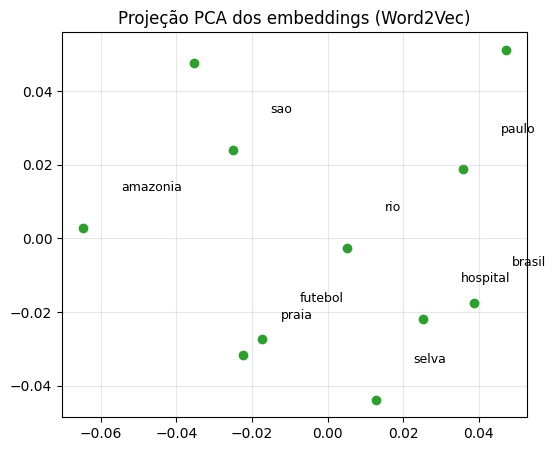

/Users/bruno/opt/anaconda3/envs/env-misc/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


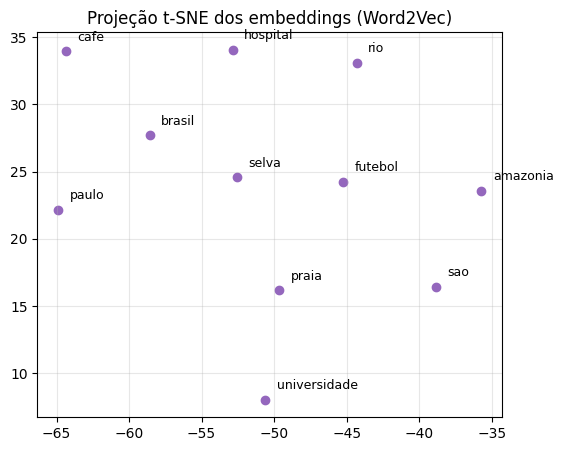

In [20]:
words_to_plot = ["brasil","rio","sao","paulo","sao_paulo","praia","futebol","universidade","hospital","amazonia","selva","cafe"]
# normalizar nomes para o vocabulário do modelo w2v
words_to_plot = [w for w in words_to_plot if w in w2v.wv]

X = np.stack([w2v.wv[w] for w in words_to_plot])

# PCA
pca = PCA(n_components=2, random_state=0)
X2 = pca.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c="tab:green")
for i,w in enumerate(words_to_plot):
    plt.annotate(w, (X2[i,0]+0.01, X2[i,1]+0.01), fontsize=9)
plt.title("Projeção PCA dos embeddings (Word2Vec)")
plt.grid(alpha=0.3)
plt.show()

# t-SNE (pode demorar um pouco com muitos pontos; aqui é pequeno)
tsne = TSNE(n_components=2, perplexity=5, learning_rate='auto', init='pca', random_state=0)
X3 = tsne.fit_transform(X)
plt.figure(figsize=(6,5))
plt.scatter(X3[:,0], X3[:,1], c="tab:purple")
for i,w in enumerate(words_to_plot):
    plt.annotate(w, (X3[i,0]+0.8, X3[i,1]+0.8), fontsize=9)
plt.title("Projeção t-SNE dos embeddings (Word2Vec)")
plt.grid(alpha=0.3)
plt.show()

## Miniaplicação: busca semântica interativa (baseline)
Dado um conjunto de frases/documentos, calculem embeddings (média de palavras) e retornem os mais parecidos para uma consulta.

In [21]:
# Vocês podem alterar a lista 'docs2' e testar consultas.
docs2 = [
    "ingressos para jogo de futebol no maracana",
    "trilha na floresta da amazonia",
    "praias de copacabana e ipanema",
    "hospital publico em sao paulo",
    "pesquisa de ia na universidade federal",
    "cafeteria tradicional no centro"
]
E2 = np.stack([sent_embed_mean(s, w2v) for s in docs2])

def search_docs(query, docs_list, E, k=3):
    qv = sent_embed_mean(query, w2v)
    scores = [cosine(qv, E[i]) for i in range(len(docs_list))]
    order = np.argsort(scores)[::-1][:k]
    return [(docs_list[i], scores[i]) for i in order]

# Exemplo
for q in ["futebol no rio", "praia", "selva amazonia", "universidade ia", "cafe"]:
    print(f"\nConsulta: {q}")
    for d,s in search_docs(q, docs2, E2, 3):
        print(f"  → {d:60s}  cos={s:.3f}")


Consulta: futebol no rio
  → ingressos para jogo de futebol no maracana                    cos=0.731
  → trilha na floresta da amazonia                                cos=0.476
  → praias de copacabana e ipanema                                cos=0.402

Consulta: praia
  → ingressos para jogo de futebol no maracana                    cos=0.479
  → hospital publico em sao paulo                                 cos=0.280
  → praias de copacabana e ipanema                                cos=0.262

Consulta: selva amazonia
  → trilha na floresta da amazonia                                cos=0.834
  → ingressos para jogo de futebol no maracana                    cos=0.659
  → pesquisa de ia na universidade federal                        cos=0.531

Consulta: universidade ia
  → pesquisa de ia na universidade federal                        cos=0.715
  → trilha na floresta da amazonia                                cos=0.249
  → ingressos para jogo de futebol no maracana                    co

## Notas críticas (viés e limitações)
- **Viés**: embeddings refletem padrões do corpus. Se os dados têm estereótipos, o vetor também terá.  
- **Contexto**: embeddings “estáticos” (Word2Vec/GloVe) **não** diferenciam sentidos: *banco* (sentar) vs *banco* (financeiro).  
- **Solução moderna**: embeddings **contextuais** (BERT/Transformers) geram vetores **por ocorrência**.

## Resumo rápido
- Embeddings: mapeiam palavras/sentenças para vetores **densos** que capturam **similaridade semântica**.  
- É possível **treinar** (Word2Vec/CBOW/Skip-gram) ou **usar pré-treinados** (fastText, Sentence-Transformers).  
- Ferramentas: similaridade por cosseno, vizinhos, analogias, PCA/t-SNE.  
- Cuidados: viés, OOV, sentidos múltiplos.

# Exercícios

In [22]:
# - Modifiquem o corpus adicionando 5–10 frases novas com tema de sua escolha (ex.: esportes, saúde, educação).
# - Re-treiem o Word2Vec (mudem window/vector_size/epochs) e observem:
#   a) Vizinhos mais próximos de 3 palavras.
#   b) Mudanças na visualização PCA.
# Dica: copiem e ajustem as células do treino e da visualização.


In [23]:
# Implementem uma função 'most_similar_to_set(positivos, negativos, topk=5)' no embedding do w2v,
# que calcula: v = sum(positivos) - sum(negativos), e retorna vizinhos de v.
# Testem casos como: positivos=['rio','praia'], negativos=['selva'].

## Leituras e recursos adicionais
**Artigos / docs (abertos):**
- Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). *Efficient Estimation of Word Representations in Vector Space* (Word2Vec).  
- Pennington, J., Socher, R., & Manning, C. D. (2014). *GloVe: Global Vectors for Word Representation*.  
- Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). *Enriching Word Vectors with Subword Information* (fastText).  
- Reimers, N., & Gurevych, I. (2019). *Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks*.  
- Goldberg, Y. (2016). *A Primer on Neural Network Models for Natural Language Processing*.